#**Task 4 Fraud Transaction Detection**

Use a dataset of credit card transactions and build a model that can identify potentially fraudulent transactions

*The Fraud Transaction Detection project aims to develop a model for identifying potentially fraudulent credit card transactions. This project employs machine learning techniques to analyze a credit card transaction dataset, preprocess the data, build and evaluate two models (Decision Tree and Random Forest), and provide insights into their performance.*

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from wordcloud import WordCloud
from termcolor import cprint

In [2]:
from nltk.corpus import stopwords
import re
import nltk

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import NuSVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [4]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = pd.read_csv('/content/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
df.shape

(284807, 31)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [9]:
df.describe

<bound method NDFrame.describe of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [12]:
print('No Frauds: ', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Frauds: ', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

No Frauds:  99.83 % of the dataset
Frauds:  0.17 % of the dataset


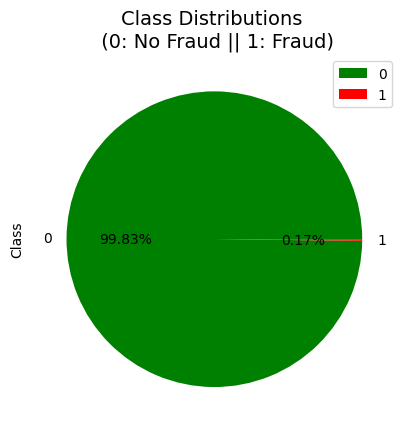

In [13]:
colors = ['green', 'red']
autopct = lambda x: f'{x:.2f}%'
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize = 14)
df['Class'].value_counts().plot(kind = 'pie', colors = colors, autopct = autopct, legend = True)
plt.savefig('Class_Distribution.png', dpi = 100)
plt.show()

In [14]:
df.drop_duplicates(keep = False, inplace = True)

In [15]:
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]
outlierFraction = len(fraud)/float(len(valid))

print(outlierFraction)
print('Fraud Cases: {}'.format(len(df[df['Class'] == 1])))
print('Valid Transaction: {}'.format(len(df[df['Class'] == 0])))

0.001628358932787715
Fraud Cases: 460
Valid Transaction: 282493


In [16]:
print('Amount details of the Fraudulent Transaction')
fraud.Amount.describe()

Amount details of the Fraudulent Transaction


count     460.000000
mean      124.045239
std       262.620752
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
print('Amount details of the Valid Transaction')
valid.Amount.describe()

Amount details of the Valid Transaction


count    282493.000000
mean         88.476932
std         250.543853
min           0.000000
25%           5.640000
50%          22.000000
75%          77.600000
max       25691.160000
Name: Amount, dtype: float64

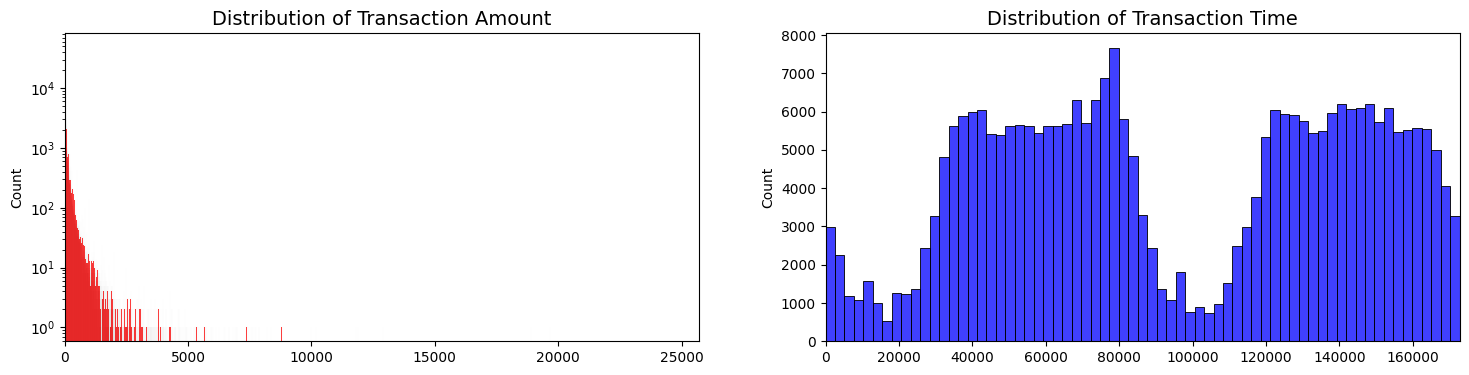

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.histplot(amount_val, ax = ax[0], color = 'r')
ax[0].set_title('Distribution of Transaction Amount', fontsize = 14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set_yscale('log')

sns.histplot(time_val, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize = 14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

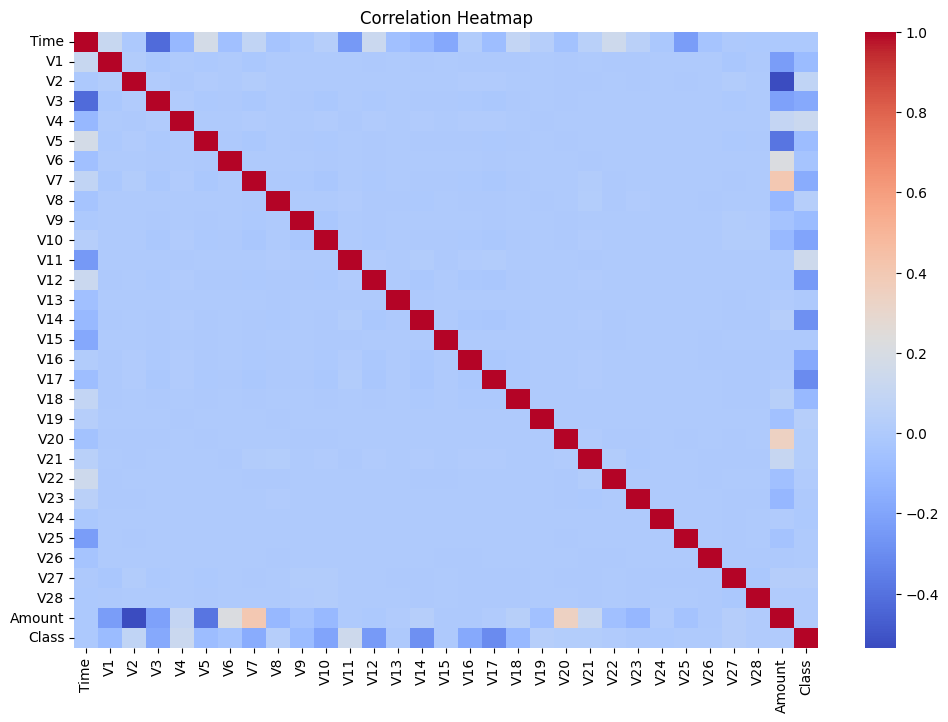

In [19]:
correlation_matrix = df.corr()
plt.figure(figsize = (12, 8))
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot = False, fmt = '.2f')
plt.title('Correlation Heatmap')
plt.show()

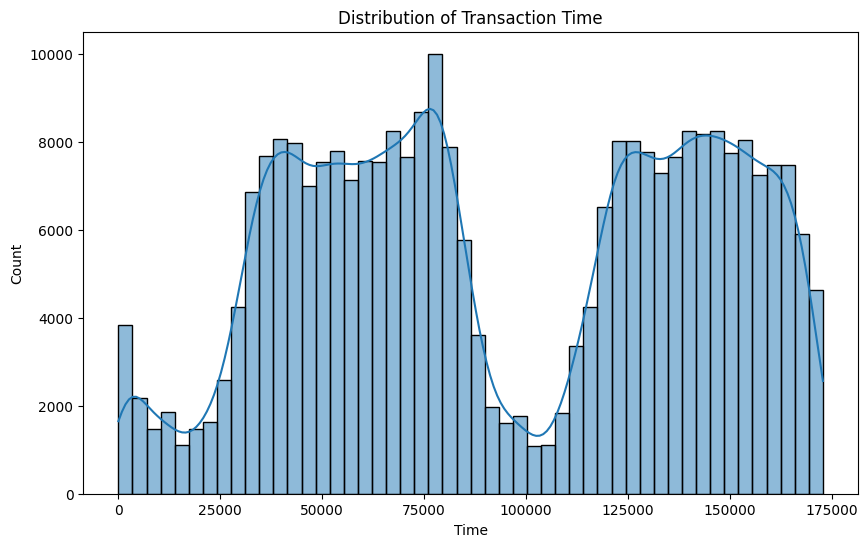

In [20]:
plt.figure(figsize = (10, 6))
sns.histplot(data = df, x = 'Time', bins = 50, kde = True)
plt.title('Distribution of Transaction Time')
plt.show()

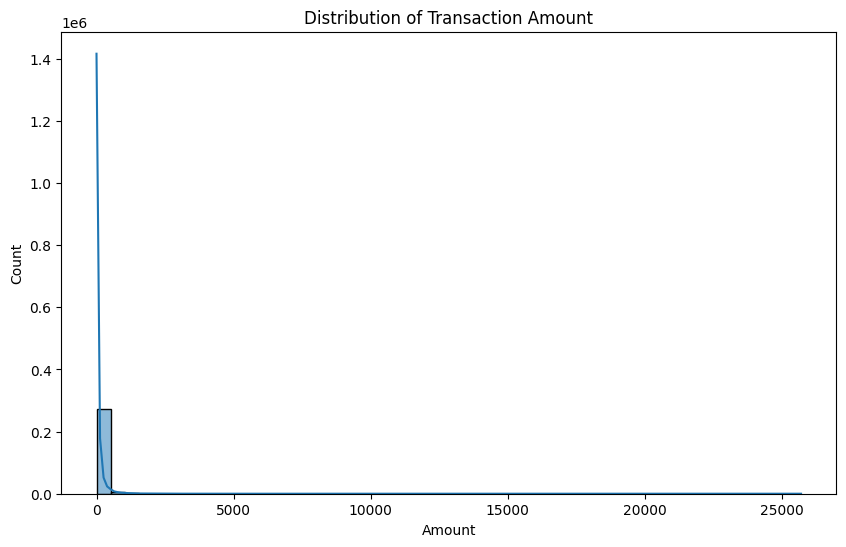

In [21]:
plt.figure(figsize = (10, 6))
sns.histplot(data = df, x = 'Amount', bins = 50, kde = True)
plt.title('Distribution of Transaction Amount')
plt.show()

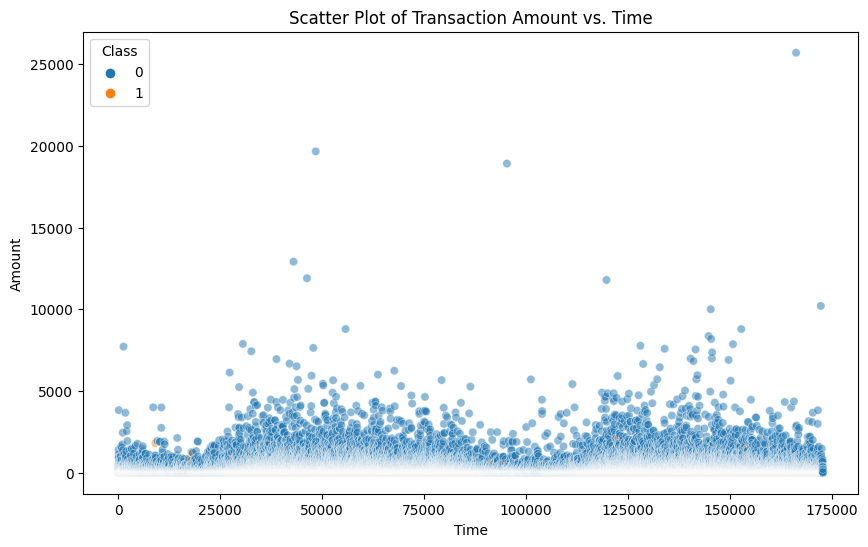

In [22]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = df, x = 'Time', y = 'Amount', hue = 'Class', alpha = 0.5)
plt.title('Scatter Plot of Transaction Amount vs. Time')
plt.show()

**Data Preprocessing**

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [26]:
x = df.drop('Class', axis = 1)
y = df['Class']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 41)

In [28]:
smote = SMOTE(sampling_strategy = 'minority')
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [31]:
datetime_features = ['date']

numeric_features = [col for col in x.columns if col not in datetime_features]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x[numeric_features], y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
dt_classifier = DecisionTreeClassifier(random_state = 42)

dt_classifier.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [35]:
y_pred = dt_classifier.predict(x_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9990634553197505


In [37]:
model_results = {}
model_name = 'Decision Tree'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results[model_name] = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

for model_name, results in model_results.items():
  print(f"Model: {model_name}")
  print(f"Accuracy: {results['Accuracy']:.2f}")
  print(f"Precision: {results['Precision']:.2f}")
  print(f"Recall: {results['Recall']:.2f}")
  print(f"F1-Score: {results['F1-Score']:.2f}")
  print("\n")

Model: Decision Tree
Accuracy: 1.00
Precision: 0.76
Recall: 0.69
F1-Score: 0.72




In [38]:
rf_classifier = RandomForestClassifier(random_state = 42)

rf_classifier.fit(x_train, y_train)

y_pred = rf_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model: Random Forest")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1=Score: ", f1)

Model: Random Forest
Accuracy:  0.9994875510240144
Precision:  0.926829268292683
Recall:  0.7676767676767676
F1=Score:  0.8397790055248618
